In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = True

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

Mounted at /content/drive


In [6]:
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/KS


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data_KS, plot_latent_states_KS 
from tools.ae_v3 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
tf.test.gpu_device_name()

''

# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '001'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_000'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']


print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']

dir_name_ae: /content/drive/MyDrive/Github/MLROM/KS/saved_ae/ae_002
normalize_flag_ogdata: False


In [12]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

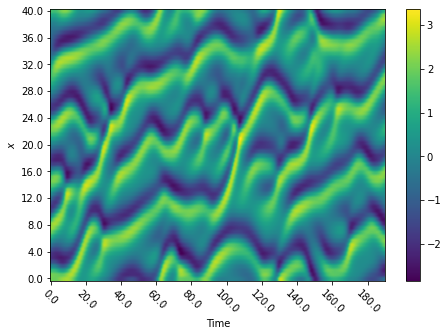

In [13]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

In [14]:
# delaing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True

    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2, numpoints_xgrid), dtype=np.float32)
        for i in range(numpoints_xgrid):
            sample_mean = np.mean(all_data[:, i])
            sample_std = np.std(all_data[:, i])
            all_data[:, i] -= sample_mean
            all_data[:, i] /= 1.414213*sample_std
            normalization_constant_arr_aedata[0, i] = sample_mean
            normalization_constant_arr_aedata[1, i] = 1.414213*sample_std

    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        'normalization_constant_arr_aedata':normalization_constant_arr_aedata
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
else:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

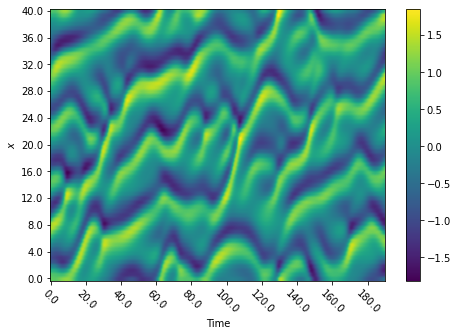

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid)

# Autoencoder

In [16]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [0.001, 0.0001, 0.00001]
    epochs = 2000
    patience = 40  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-5  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [17]:
# setting up data
idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)
boundary = int(np.round((1-test_split)*all_data.shape[0]))
training_data = all_data[idx[0:boundary], :]
testing_data = all_data[idx[boundary:], :]

In [18]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    ae_net = Autoencoder(
        data_dim=all_data.shape[1],
        enc_layers=[128, 96, 64, 48],
        dec_layers=[48, 64, 96, 128],
        latent_space_dim=32,
        lambda_reg=lambda_reg,
        reg_name='L2',
        enc_layer_act_func='elu',
        enc_final_layer_act_func='tanh',
        dec_layer_act_func='elu',
        dec_final_layer_act_func='linear',
        load_file=None)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
    ae_net.load_weights_from_file(wt_file)

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [20]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=5  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=5)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
            validation_split=val_split/train_split,
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))

Streaming output truncated to the last 5000 lines.
Epoch 656/2000
24/24 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 657/2000
22/24 [==========================>...] - ETA: 0s - loss: 0.0021 - tot_time: 0h 4m 45.3s

Epoch 657: val_loss improved from 0.00213 to 0.00213, saving model to /content/drive/MyDrive/Github/MLROM/KS/saved_ae/ae_002/checkpoints/checkpoint
24/24 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 658/2000
24/24 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 659/2000
24/24 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 660/2000
17/24 [====================>.........] - ETA: 0s - loss: 0.0021 - tot_time: 0h 4m 46.1s
 - saving loss histories at /content/drive/MyDrive/Github/MLROM/KS/saved_ae/ae_002/checkpoints/LossHistoriesCheckpoint
24/24 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss

In [21]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = ae_net.evaluate(
        testing_data, testing_data,
    )

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

6/6 [==============================] - 0s 5ms/step - loss: 0.0020


In [22]:
lr_change

[0, 543, 2543, 2584]

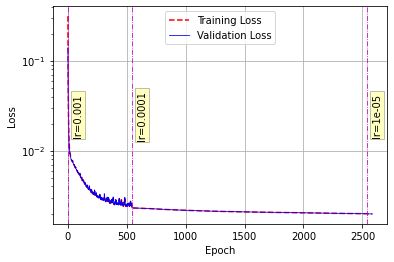

In [23]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_ae+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [24]:
reconstructed_data = ae_net.predict(all_data)

60/60 [==============================] - 0s 2ms/step


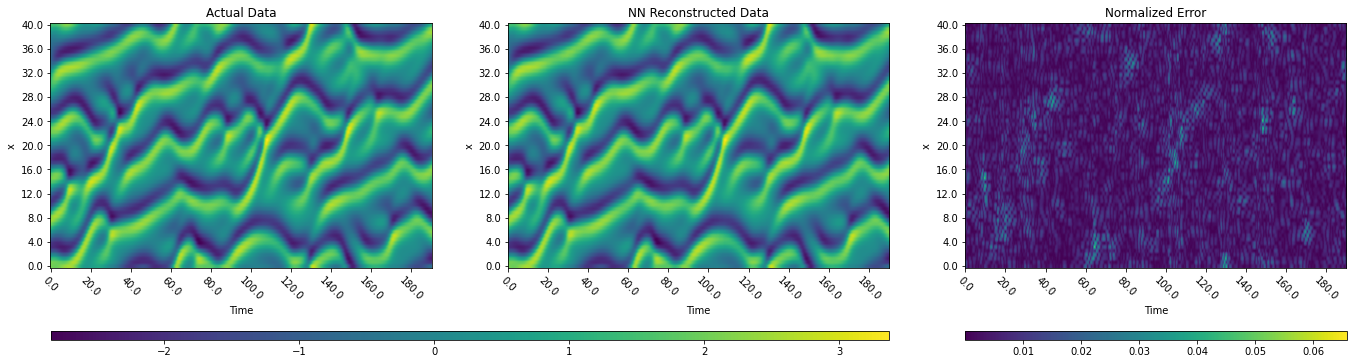

In [25]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=False,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=20,
    num_yticks=11)

In [26]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=True,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=20,
    num_yticks=11)

In [27]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

60/60 [==============================] - 0s 2ms/step


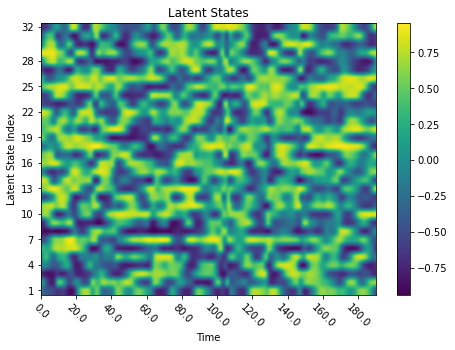

In [28]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=20,
    num_yticks=11,
    save_figs=False)

In [29]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=20,
    num_yticks=11,
    save_figs=True)

In [30]:
# ae_net.summary()